In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import utm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split



import tensorflow as tf
import keras
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the data

In [60]:
sensor_and_loc_file = '../data/Processed/full_sensor_data_no_interpol_and_location.csv'

In [61]:
df_sensor_and_loc = pd.read_csv(sensor_and_loc_file, index_col=0)
df_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:61,0.412078860000000,0.443542480000000,9.409470000000001,0.032653810000000,0.321075440000000,-0.377655030000000,NaN,NaN,NaN,9.428927012090160,0.496768589146909,NaN,NaN,NaN
12:15:51:62,0.378555300000000,0.465087900000000,9.435805999999999,0.018798828000000,0.324279800000000,-0.366989140000000,NaN,NaN,NaN,9.454842449217251,0.490093678290338,NaN,NaN,NaN
12:15:51:63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:27:16,1.302719100000000,0.520156860000000,7.142166000000000,-0.118621826000000,-0.505569460000000,0.092132570000000,NaN,NaN,NaN,7.278610814164050,0.527408785424618,NaN,NaN,NaN
19:09:27:17,2.049713100000000,0.280731200000000,8.202788999999999,-0.301849370000000,-0.332992550000000,0.140075680000000,23.100280000000001,-16.200256000000000,-262.800599999999974,8.459662001373697,0.470763503951147,264.310852200404213,NaN,NaN
19:09:27:18,2.140686000000000,0.043701172000000,9.170044000000001,-0.590530400000000,0.304031370000000,0.046325684000000,23.100280000000001,-13.949585000000001,-261.749270000000024,9.416695455676912,0.665813259304968,263.136645496752351,NaN,NaN
19:09:27:19,1.896484400000000,-0.226837160000000,9.799728000000000,-0.686401370000000,0.651306150000000,-0.067657470000000,NaN,NaN,NaN,9.984126253738191,0.948643281224560,NaN,NaN,NaN


In [62]:
df_sensor_and_loc.loc[:, 'lat'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.loc[:, 'long'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.dropna(inplace=True)
df_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:68,0.752044700000000,0.659011840000000,9.081467000000000,0.064605710000000,0.363693240000000,-0.362731930000000,52.499389999999998,-50.399780000000000,-261.300659999999993,9.136351060907591,0.517707565743274,271.245937648577694,44.434937499999961,26.047602129736543
12:15:51:70,0.764022800000000,0.639862060000000,8.693603500000000,-0.093048096000000,0.537323000000000,-0.366989140000000,53.250121999999998,-49.650573999999999,-260.699459999999988,8.750536904096773,0.657308894946786,270.675014428439624,44.434937499999954,26.047602287170676
12:15:51:72,0.761627200000000,0.601547240000000,8.547561999999999,-0.231536870000000,0.496841430000000,-0.382980350000000,53.700256000000003,-51.600647000000002,-261.000060000000019,8.602485176829743,0.668681297196179,271.417345770840086,44.434937499999947,26.047602444604813
12:15:51:75,1.024993900000000,0.424377440000000,9.782973999999999,-0.580947900000000,0.266754150000000,-0.371261600000000,54.600524999999998,-48.300170000000001,-260.850520000000017,9.845673617954953,0.739251929108875,270.845191089993193,44.434937499999933,26.047602680756018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:27:10,0.866973900000000,-0.753570560000000,11.801285000000000,1.092590300000000,0.211364750000000,-0.624786400000000,22.200012000000001,-11.099243000000000,-260.850520000000017,11.857058656488332,1.276239267074012,262.028676889083272,44.434937499964619,26.047602549477574
19:09:27:12,1.384124800000000,-0.945098900000000,10.108582000000000,1.477142300000000,0.371154800000000,-0.779251100000000,22.349547999999999,-12.449646000000000,-262.500000000000000,10.246582037122440,1.710829487957096,263.743712685875437,44.434937499964605,26.047602339565394
19:09:27:15,0.629943850000000,0.611129760000000,6.129410000000000,0.447036740000000,-0.437393200000000,-0.180572510000000,22.200012000000001,-14.100647000000000,-262.950130000000001,6.191928276862587,0.650969346193634,264.262066225244780,44.434937499964590,26.047602024697124
19:09:27:17,2.049713100000000,0.280731200000000,8.202788999999999,-0.301849370000000,-0.332992550000000,0.140075680000000,23.100280000000001,-16.200256000000000,-262.800599999999974,8.459662001373697,0.470763503951147,264.310852200404213,44.434937499964576,26.047601814784940


In [85]:
data = df_sensor_and_loc.copy(deep=True)[::10]
data.shape

(3108, 14)

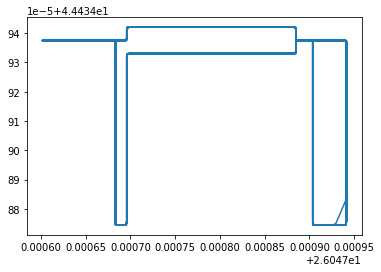

In [86]:
plt.plot(data['long'], data['lat'])

# 2. Creating the LSTM model

## 2.1. Scaling the data

In [87]:
backcandles=30  # number of last values to look into
attributes_cols=12
pca_components=9
num_cols_to_eliminate=attributes_cols-data.shape[1]

# Separate features (X) and target (y)
attributes = data.iloc[:, :num_cols_to_eliminate]  # Assuming the target columns are the last two columns
targets = data.iloc[backcandles:, num_cols_to_eliminate:]  # Assuming the target columns are the last two columns
attributes.columns, targets.columns

(Index(['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'a_total',
        'g_total', 'm_total'],
       dtype='object'),
 Index(['lat', 'long'], dtype='object'))

In [88]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(attributes)

In [89]:

# Apply PCA with 3 desired components
# pca = PCA(n_components=pca_components)
# X_pca = pca.fit_transform(X_scaled)
# X_pca.shape

In [90]:
X = []

for i in range(pca_components): #number of attributes columns
    X.append([])
    for j in range(backcandles, X_scaled.shape[0]):
        X[i].append(X_pca[j-backcandles:j, i])
        
# move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

# We need shape (8581, 30, 12) = (rows, val of past attributes, columns) for LSTM training
X.shape

(3078, 30, 9)

In [91]:
X, y = np.array(X), np.array(targets)

print('X Shape: ',X.shape)
print('y shape: ', y.shape)

X Shape:  (3078, 30, 9)
y shape:  (3078, 2)


In [92]:
splitlimit_test = int(len(X) * 0.7)
splitlimit_val = int(len(X) * 0.9)

print(splitlimit_test, splitlimit_val)
X_train, X_test, X_val = X[:splitlimit_test], X[splitlimit_test:splitlimit_val], X[splitlimit_val:]
y_train, y_test, y_val = y[:splitlimit_test], y[splitlimit_test:splitlimit_val], y[splitlimit_val:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

2154 2770
(2154, 30, 9)
(616, 30, 9)
(308, 30, 9)
(2154, 2)
(616, 2)
(308, 2)


In [93]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(backcandles, pca_components)))  # 2 LSTM layers
model.add(Dropout(0.2))  # 2 Dropout layers
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(2))  # 1 Dense layer for output
model.compile(optimizer=RMSprop(learning_rate=0.005), loss='mse', metrics=['mse', 'mae', 'accuracy'])

In [94]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [95]:
batch_size=100
epochs=30

# Train the LSTM model
model.fit(X_train, 
          y_train, 
          epochs=epochs, 
          batch_size=batch_size, 
          validation_data=(X_test, y_test))

Epoch 1/30
22/22 [==============================] - 15s 312ms/step - loss: 716.3527 - mse: 716.3527 - mae: 25.5754 - accuracy: 0.9717 - val_loss: 435.9575 - val_mse: 435.9575 - val_mae: 20.0321 - val_accuracy: 1.0000
Epoch 2/30
22/22 [==============================] - 3s 145ms/step - loss: 323.0489 - mse: 323.0489 - mae: 16.9275 - accuracy: 1.0000 - val_loss: 214.6122 - val_mse: 214.6122 - val_mae: 13.6192 - val_accuracy: 1.0000
Epoch 3/30
22/22 [==============================] - 3s 126ms/step - loss: 152.1135 - mse: 152.1135 - mae: 10.9662 - accuracy: 1.0000 - val_loss: 88.7604 - val_mse: 88.7604 - val_mae: 8.1113 - val_accuracy: 1.0000
Epoch 4/30
22/22 [==============================] - 2s 113ms/step - loss: 59.2581 - mse: 59.2581 - mae: 6.1454 - accuracy: 1.0000 - val_loss: 26.6333 - val_mse: 26.6333 - val_mae: 3.8811 - val_accuracy: 1.0000
Epoch 5/30
22/22 [==============================] - 3s 116ms/step - loss: 17.9004 - mse: 17.9004 - mae: 3.2138 - accuracy: 1.0000 - val_loss: 3.

In [96]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])
len(y_pred), len(y_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

y_pred, y_test

20/20 [==============================] - 4s 34ms/step
[43.977463 25.804825] [44.4349375  26.04767115]
[43.977463 25.804825] [44.4349375  26.04767049]
[43.977463 25.804825] [44.4349375  26.04766989]
[43.97746  25.804825] [44.4349375  26.04766923]
[43.97746  25.804825] [44.4349375 26.0476686]
[43.97746  25.804825] [44.4349375  26.04766797]
[43.97746  25.804825] [44.4349375  26.04766721]
[43.97746  25.804825] [44.4349375  26.04766649]
[43.97746  25.804825] [44.4349375  26.04766589]
[43.97746  25.804825] [44.4349375  26.04766526]
Mean Squared Error (MSE): 0.13414368986032266
R-squared: -271479909.5371124


(array([[43.977463, 25.804825],
        [43.977463, 25.804825],
        [43.977463, 25.804825],
        ...,
        [43.97746 , 25.804825],
        [43.97746 , 25.804823],
        [43.97746 , 25.804823]], dtype=float32),
 array([[44.4349375 , 26.04767115],
        [44.4349375 , 26.04767049],
        [44.4349375 , 26.04766989],
        ...,
        [44.434933  , 26.04774791],
        [44.434933  , 26.04775106],
        [44.434933  , 26.04775421]]))

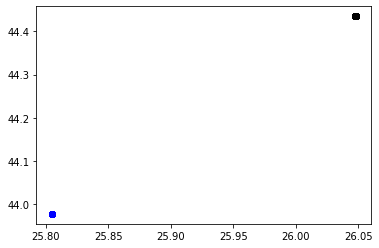

In [98]:
plt.scatter(y_test[:, 1], y_test[:, 0], color='black', label='Test')
plt.scatter(y_pred[:, 1], y_pred[:, 0], color='blue', label='Pred')

In [31]:
test = [
        [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
        [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
        [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
            [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
            [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
            [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
            [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
            [
           [1, 2], [2, 3], [3, 3], [4,3]
        ],
            [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
            [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
            [
            [1, 2], [2, 3], [3, 3], [4,3]
        ],
            [
            [1, 2], [2, 3], [3, 3], [4,3]
        ]
       ]

In [32]:
test =np.array(test)
test.shape

(12, 4, 2)

In [33]:
test = np.moveaxis(test, [0], [2])
test.shape

(4, 2, 12)

In [24]:
data = {'c1': [1, 2, 3, 4, 5, 6], 'c2': [7, 8, 9, 10, 11, 12], 'c3': [7, 8, 9, 10, 11, 12]}
d_t = pd.DataFrame(data)

In [26]:
sc_attributes = MinMaxScaler(feature_range=(-1, 1))
attributes_scaled = sc_attributes.fit_transform(d_t.iloc[:, :2])
attributes_scaled

array([[-1. , -1. ],
       [-0.6, -0.6],
       [-0.2, -0.2],
       [ 0.2,  0.2],
       [ 0.6,  0.6],
       [ 1. ,  1. ]])

In [28]:
attributes_scaled[:3, 0], attributes_scaled[3:, 0]

(array([-1. , -0.6, -0.2]), array([0.2, 0.6, 1. ]))